# Theory where there is deep convection
This looks at the theory plot, but only considers days for which deep convection is occuring.
It is a repeat of `tau_sweep/aquaplanet/publish_figures/free_trop/single_kappa/`

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-01-15 16:15:31,437 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'aquaplanet/temp_tendency/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [88]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)
use_time_start = 360*2
lzb_thresh = 12     # Need klzb to be lower than this so LZB is less than 560hPa (14) or 413hPa (12)
convflag_thresh = 1.8       # Need more than this to be considered deep convection

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where(np.logical_and(ds_use.klzbs<lzb_thresh, ds_use.convflag > convflag_thresh))

        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)
p_surface = float(ds_all[0].pfull[0]) * 100
pressure_ft_actual = float(ds_all[0].pfull[-1]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:13<00:00,  6.65s/it]


In [89]:
n_pressure = len(ds[0].pfull)
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(n_pressure), ds[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    k = np.clip(k, 1, np.inf)
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

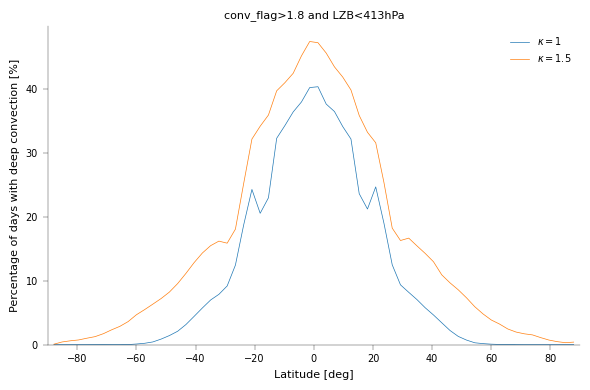

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True, sharey=True)
for i in range(n_exp):
    ax.plot(ds_all[i].lat, 100*(ds_all[i].temp[0]>0).sum(dim='lon_time')/ds_all[i].dims['lon_time'], 
               label=f"$\kappa = {tau_lw[i]}$")
ax.legend()
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Percentage of days with deep convection [%]')
ax.set_xlim(-90, 90)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_title(f"conv_flag>{convflag_thresh} and LZB<{int(lzb(lzb_thresh))}hPa")
plt.tight_layout()

In [91]:
# Get values averaged around a surface temperature percentile, rather than exactly on it.
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
n_lat = ds_all[0].lat.shape[0]
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

# Note the quant3_type doesn't make much difference and only really makes a difference in the tropics
# where the equivalence of the temperature and moist static energy percentiles is not as valid.
quant3_method = 'temp'            # Take percentile to be temperature percentile      (this is legacy, what I was doing previously)
# quant3_method = 'mse'             # Take percentile to be of near-surface mse (think this is correct version of theory)
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant)) 
temp_median = np.zeros((n_exp, n_pressure, n_lat))
temp_mean = np.zeros((n_exp, n_pressure, n_lat))   
# In free troposphere, this is saturated MSE.
mse_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant))  
mse_mean = np.zeros((n_exp, n_pressure, n_lat))
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse = moist_static_energy(ds_all[i].temp[0], ds_all[i].sphum[0], ds_all[i].height[0])
        mse_ft = moist_static_energy(ds_all[i].temp[-1], sphum_sat(ds_all[i].temp[-1], pressure_ft_actual), ds_all[i].height[-1])
        mse_mean[i, 0] = mse.mean(dim='lon_time')
        mse_mean[i, 1] = mse_ft.mean(dim='lon_time')
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        temp_median[i] = ds_all[i].temp.median(dim='lon_time')
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                if quant3_method == 'temp':
                    use_ind = get_quant_ind(ds_all[i].temp[0, k], quant, 0.5, 0.5)
                elif quant3_method == 'mse':
                    use_ind = get_quant_ind(mse[k], quant, 0.5, 0.5)
                else:
                    raise ValueError('quant3_type not valid')
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time')
                mse_quant3[i, 0, k, j] = mse[k, use_ind].mean(dim='lon_time')           # this is the same as mse_quant2 if quant3_type == mse
                mse_quant3[i, 1, k, j] = mse_ft[k, use_ind].mean(dim='lon_time')
                pbar.update(1)

  0%|          | 0/12672 [00:00<?, ?it/s]/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
  0%|          | 1/12672 [00:00<1:10:31,  2.99it/s]/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/joshduffiel

## $\lambda$ Decompostion
### Combine latitudes
Here, I break down the $\lambda=1$ approximation into three different factors. $\lambda_1$ represents CQE on the $x$ percentile day. $\lambda_2$ represents the weak temperature gradient approximation and $\lambda_3$ represents CQE on the mean day.

Note the black line below differs from actual $\lambda$ because here I am plotting it as a function of near-surface temperature percentile, whereas for lambda plot in `surface/single_kappa` notebook, I plot it as a function of near-surface MSE percentile. I.e. the x-axis are different.

In [92]:
lambda_1 = (mse_quant3[1] - mse_quant3[0])[0] / (mse_quant3[1]-mse_quant3[0])[1]
lambda_2 = (mse_quant3[1]-mse_quant3[0])[1] / np.expand_dims(mse_mean[1]-mse_mean[0], axis=-1)[1]
lambda_3 = (mse_mean[1]-mse_mean[0])[0] / (mse_mean[1]-mse_mean[0])[1]
labels = ['$\lambda(x) = \lambda_1(x) \lambda_2(x) / \overline{\lambda_1}$',
          '$\lambda_1(x)$',
          '$\lambda_2(x)$',
          '$\overline{\lambda_1}$']

In [93]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

lat_use = np.where((np.abs(ds_all[0].lat) <= lat_max) & (np.abs(ds_all[0].lat) >= lat_min))[0]
lat_weights_use = lat_weights[lat_use]

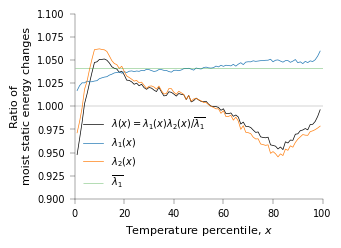

In [94]:
save_lambda_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quant_plot, np.average(var[lat_use], axis=0, weights=lat_weights_use),
            color=use_color, label=labels[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(np.average(lambda_3[lat_use], axis=0, weights=lat_weights_use), 0, 100, color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, 0, 100, color='k', lw=ax_linewidth, alpha=0.5)
ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(0.9, 1.1)
ax.set_xlabel(f"{'Temperature percentile' if quant3_method=='temp' else 'Moist static energy percentile'}, $x$")
ax.set_ylabel('Ratio of\nmoist static energy changes')
if save_fig or save_lambda_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### High percentiles as function of latitude
In the plot below, the quantiles in the order $90, 95, 99$ are represented in terms of lines of increasing opacity i.e. the darkest lines represent $x=99$.

In [95]:
def abs_lat_av(var):
    # averages across indices with the same absolute latitude
    var_av = np.zeros(int(len(var)/2))
    for i in range(len(var_av)):
        var_av[i] = np.mean([var[i], var[-1-i]])
    return var_av[::-1]     # invert order so latitude is increasing

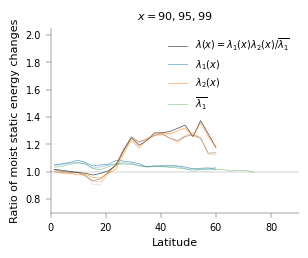

In [96]:
quant_subset = [90,95,99]
# quant_subset = [10,5,1]
quant_subset_ind = numpy_indexed.indices(quant_plot, quant_subset)
quant_subset_alpha = [0.1+i*(0.9/len(quant_subset)) for i in range(len(quant_subset))]
lat_plot = ds_all[0].lat[int(n_lat/2):]

save_lambda_decomp_lat_fig = False
fig_lambda_decomp, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]), alpha=quant_subset_alpha[0], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]), alpha=quant_subset_alpha[1], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]), alpha=quant_subset_alpha[2], color=use_color, label=labels[i])
ax.plot(lat_plot, abs_lat_av(lambda_3), color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
ax.set_xlim(0, 90)
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Ratio of moist static energy changes')
ax.set_title('$x=90, 95, 99$')
# ax.set_title('$x=10, 5, 1$')
ax.set_ylim(0.7,2.05)
if (save_fig or save_lambda_decomp_lat_fig):
    fig_lambda_decomp.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_lat_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\lambda_2$ Decomposition
$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$ can be split up into a product of two terms:
$$\lambda_2(x) = \frac{c_p+L_v\alpha(T_{FT}(x))q^*(T_{FT}(x))}{c_p+L_v\alpha(\overline{T_{FT}})q^*(\overline{T_{FT}})} \times
\frac{\delta T_{FT}(x)}{\delta \overline{T_{FT}}$$
The first term being just evaluated at the historical simulation, and the second incorporating temperature changes. This equation assumes no changes to the geopotential height term, but in zhang 2023, these can be related to temperature as well.
I label these contributions as $\lambda_{2_0}$ and $\lambda_{2_{\delta}}$ respectively.

The black and blue lines below differ, indicating that the geopotential height or potentialy squared temperature, $\delta T^2$ terms may be important.

In [97]:
lambda_2_0 = (c_p + L_v * clausius_clapeyron_factor(temp_quant3[0, 1], pressure_ft_actual) *
              sphum_sat(temp_quant3[0, 1], pressure_ft_actual)) / np.expand_dims(
    c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual), axis=-1)
# lambda_2_0 = lambda_2_0 + np.expand_dims((9.81*ds_all[0].height[1].mean(dim='lon_time')/temp_mean[0, 1]) / (c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual)), axis=-1)
# lambda_z = temp_quant3[0, 1]*9.81*np.expand_dims(ds_all[0].height[1].mean(dim='lon_time'), axis=-1)/np.expand_dims(temp_mean[0, 1]**2*(c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual)), axis=-1)
lambda_2_delta = (temp_quant3[1]-temp_quant3[0])[1]/np.expand_dims(temp_mean[1]-temp_mean[0], axis=-1)[1]

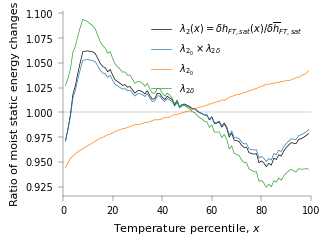

In [98]:
save_lambda2_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
labels_lambda2 = ['$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$',
                  '$\lambda_{2_0} \\times \lambda_{2\delta}$', '$\lambda_{2_0}$', '$\lambda_{2\delta}$']
for i, var in enumerate([lambda_2, lambda_2_0 * lambda_2_delta, lambda_2_0, lambda_2_delta]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quant_plot, np.average(var[lat_use], axis=0, weights=lat_weights_use),
            color=use_color, label=labels_lambda2[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(1, 0, 100, color='k', alpha=0.5, lw=ax_linewidth)
ax.legend()
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Ratio of moist static energy changes')
if save_fig or save_lambda2_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda2_decomp_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

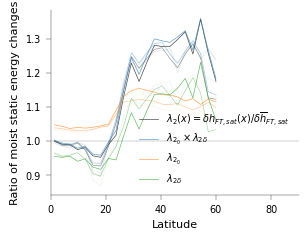

In [99]:
save_lambda2_decomp_lat_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i, var in enumerate([lambda_2, lambda_2_0 * lambda_2_delta, lambda_2_0, lambda_2_delta]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]), alpha=quant_subset_alpha[0], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]), alpha=quant_subset_alpha[1], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]), alpha=quant_subset_alpha[2], color=use_color, label=labels_lambda2[i])
ax.hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
ax.set_xlim(0, 90)
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Ratio of moist static energy changes')
if (save_fig or save_lambda2_decomp_lat_fig):
    fig.savefig(f"/Users/joshduffield/Desktop/lambda2_decomp_lat_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

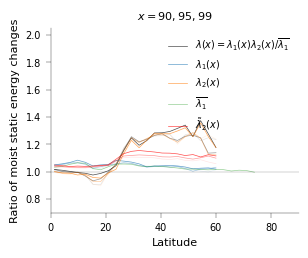

In [100]:
save_lambda_decomp_lat_fig2 = False
fig = copy.deepcopy(fig_lambda_decomp)
ax = fig.gca()
for i in range(len(quant_subset)):
    ax.plot(lat_plot, abs_lat_av(lambda_2_0[:, quant_subset_ind[i]]), color='r', 
            label='$\\tilde{\lambda}_2(x)$' if i==len(quant_subset)-1 else None, alpha=quant_subset_alpha[i] )
ax.legend()
if (save_fig or save_lambda_decomp_lat_fig2):
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_lat2_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, pad_inches=save_pad_inches)
fig

### Add $\lambda_{2_0}$ to theory
The orange line in the theory below assumes that $\lambda_1 = \lambda_3$ and $\lambda_2 = \lambda_{2_0}$. These combine to give $\lambda = \lambda_{2_0}$ rather than $\lambda=1$.

This seems to improve things at higher latitudes but only because the $\lambda_1 = \lambda_3$ approximation breaks down in the opposite way so you get cancellation of errors.
I.e. we assume that $\lambda_3 \approx \lambda_1$ and $\lambda_2 \approx \lambda_{2_0}$. When actually at high latitudes, $\lambda_3 > \lambda_1$ and $\lambda_2 > \lambda_{2_0}$. Because $\lambda = \lambda_1 \lambda_2 / \lambda_3$, if we underestimate both $\lambda_3$ and $\lambda_2$, then these effects offset each other.

In [101]:
# Obtain surface quantities required for theories
sphum_mean = np.zeros((n_exp, n_lat))
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_lat, n_quant))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_lat, n_quant))

for i in tqdm(range(n_exp)):
    ds_use = ds_all[i].sel(pfull=p_surface/100)
    sphum_mean[i] = ds_use.sphum.mean(dim='lon_time')
    temp_quant2[i] = ds_use.temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    sphum_quant2[i] = ds_use.sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    mse = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
    mse_quant2[i] = mse.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()

temp_diff_theory = {method: np.zeros((n_lat, n_quant)) for method in ['linear', 'lambda_2']}
for method in temp_diff_theory:
    for i in range(n_lat):
        temp_diff_theory[method][i] = \
            get_delta_temp_quant_theory(temp_mean[:, 0, i], sphum_mean[:, i], temp_quant2[:, i], sphum_quant2[:, i], p_surface,
                                        const_rh=False, delta_mse_ratio=lambda_2_0[i:i+1] if 'lambda' in method else None,
                                        taylor_level='linear_rh_diff')
delta_mse_ratio = (mse_quant2[1]-mse_quant2[0])/np.expand_dims((mse_mean[1]-mse_mean[0])[0], axis=-1)

  0%|          | 0/2 [00:00<?, ?it/s]/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


In [102]:
scaling_factor_av = 'mean'    # Mean will use quantile closest to mean at each latitude
# scaling_factor_av = 'median'  # take median as average rather than mean because theory does not predict change to mean temperature
# scaling_factor_av_type = 'theory'
scaling_factor_av_type = 'simulated'     # If 'simulated', will use theoretical mean/median temp diff to compute theoretical scale factor too

av_quant_ind = np.where(quant_plot==50)[0]
if scaling_factor_av == 'mean':
    # Find temperature quantile if historical climate closest to mean
    av_quant_ind = [int(np.round(scipy.stats.percentileofscore(ds_all[0].temp[0][i], float(ds_all[0].temp[0][i].mean())))) 
                    for i in range(n_lat)]
else:
    av_quant_ind = [50]*n_lat
av_quant_ind = numpy_indexed.indices(quant_plot, np.asarray(av_quant_ind))
av_quant_flat_ind = np.ravel_multi_index((np.arange(n_lat), av_quant_ind), temp_quant2[0].shape)
sf_denom = {key: temp_diff_theory[key].flatten()[av_quant_flat_ind] for key in temp_diff_theory.keys()}
if scaling_factor_av == 'mean':
    sf_denom['simulated'] = temp_mean[1, 0]-temp_mean[0, 0]
else:
    sf_denom['simulated'] = (temp_quant2[1]-temp_quant2[0]).flatten()[av_quant_flat_ind]
for key in sf_denom:
    sf_denom[key] = np.expand_dims(sf_denom[key], axis=-1)
    
if scaling_factor_av_type == 'simulated':
    for key in temp_diff_theory.keys():
        # Set all theoretical mean/median predictions to the simulated
        sf_denom[key] = sf_denom['simulated'] 

ValueError: cannot convert float NaN to integer

In [ ]:
save_lambda2_theory_fig = False
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 0.75*3*width['one_col']/ar), sharex=True)
ax[0].plot(quant_plot, np.average((temp_quant2[1]-temp_quant2[0])[lat_use], axis=0, weights=lat_weights_use), 
           label = 'Simulated', color='blue')
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'][lat_use], axis=0, weights=lat_weights_use), color='k', linestyle='--',
           label='Original theory')
ax[0].plot(quant_plot, np.average(temp_diff_theory['lambda_2'][lat_use], axis=0, weights=lat_weights_use), color=default_colors[1],
           label='Modified theory')
ax[1].plot(quant_plot, 
           np.average((temp_quant2[1]-temp_quant2[0])[lat_use]/sf_denom['simulated'][lat_use],
                                  axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
ax[1].plot(quant_plot, np.average(temp_diff_theory['linear'][lat_use]/sf_denom['linear'][lat_use], 
                                  axis=0, weights=lat_weights_use), color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(temp_diff_theory['lambda_2'][lat_use]/sf_denom['lambda_2'][lat_use], 
                                  axis=0, weights=lat_weights_use), color=default_colors[1])
# Add lambda comparison
for i, var in enumerate([delta_mse_ratio, lambda_2_0]):
    ax[2].plot(quant_plot, np.average(var[lat_use], axis=0, weights=lat_weights_use),
            color='b' if i == 0 else default_colors[1], label='$\lambda$' if i==0 else '$\lambda_{2_0}$')
ax[1].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=ax_linewidth)
ax[2].hlines(1, -10, 100, linestyles='--', color='k')
ax[2].set_ylabel('Ratio of moist static energy changes')
ax[2].legend()
ax[0].legend()
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ / $K$')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
# ax[0].set_ylim(4,12)
# ax[1].set_ylim(0.55,1.6)
# ax[2].set_ylim(0.75,1.5)

if save_fig or save_lambda2_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_lambda2_theory_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [ ]:
save_theory_lambda2_lat_fig = False
norm_by_sf = True
if norm_by_sf:
    denom = {key: sf_denom[key].flatten() for key in sf_denom}
else:
    denom = {key: 1 for key in sf_denom}
include_theory = True
fig_theory_lat, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(len(quant_subset)):
    ax.plot(lat_plot, abs_lat_av((temp_quant2[1, :, quant_subset_ind[i]]-temp_quant2[0, :, quant_subset_ind[i]])/
                                 denom['simulated']), color='r', alpha=quant_subset_alpha[i],
            label='Simulated' if i==2 else None)
    if include_theory:
        ax.plot(lat_plot, abs_lat_av(temp_diff_theory['linear'][:, quant_subset_ind[i]]/
                                     denom['linear']), color='k', alpha=quant_subset_alpha[i],
                label='Original theory' if i==2 else None)
        ax.plot(lat_plot, abs_lat_av(temp_diff_theory['lambda_2'][:, quant_subset_ind[i]]/
                         denom['lambda_2']), color=default_colors[2], alpha=quant_subset_alpha[i],
        label='Modified theory' if i==2 else None)
ax.set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax.set_xlabel('Latitude')
if include_theory:
    ax.legend(frameon=False)
ax.set_xlim(0,90)
# ax.set_ylim(0.4, 1.05)
if (save_fig or save_theory_lambda2_lat_fig):
    fig_theory_lat.savefig(f"/Users/joshduffield/Desktop/temp_theory_lambda2_lat_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)